<a href="https://colab.research.google.com/github/myutman/DUL/blob/HW2/HW21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.functional import F

In [0]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]
    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [0]:
def display(X, y):
    colors = np.array(['red', 'green', 'blue'])
    plt.scatter(x=X[:,0], y=X[:,1], c=colors[y], cmap='cyan')
    plt.show()

#1.1 

In [0]:
class MaskedLayer(nn.Linear):
    def __init__(self, m_in, m_out):
        super(MaskedLayer, self).__init__(len(m_in), len(m_out))
        a = m_in.reshape((1, len(m_in)))
        b = m_out.reshape((len(m_out), 1))
        self.mask = (a <= b).float()
    
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedLayer, self).forward(x)


class MADE(nn.Module):
    def __init__(self, n_out):
        super(MADE, self).__init__()
        self.n_out = n_out
        hidden_size = 10
        n_hidden = 2
        start_m = torch.tensor([1, 2])
        m1 = start_m
        m2 = torch.ones(hidden_size)
        self.layers = [
            MaskedLayer(m1, m2),
            nn.Sigmoid(),
            #Dropout(0.2)
        ]
        for i in range(1, n_hidden - 1):
            m1 = m2
            m2 = torch.ones(hidden_size)
            self.layers.extend([
                MaskedLayer(m1, m2),
                nn.Sigmoid(),
                #Dropout(0.2)
            ])
        m1 = m2
        m2 = torch.tensor([0] * n_out + [1] * n_out)
        self.layers.append(MaskedLayer(m1, m2))
        self.seq = nn.Sequential(*self.layers)
    
    def forward(self, x):
        z = self.seq(x)
        return z.reshape(-1, 2, self.n_out)

def normal_pdf(x, mu, sigma):
    return torch.exp(-(x - mu)**2 / (2 * sigma)) / (torch.sqrt(2 * np.pi * sigma))

class FlowModel(nn.Module):
    def __init__(self, k):
        super(FlowModel, self).__init__()
        self.k = k
        self.pi_made = nn.Sequential(MADE(k), nn.Softmax(dim=-1))
        self.mu_made = MADE(k)
        self.sigma_made = MADE(k)
        self.norm = torch.distributions.normal.Normal(0, 1)

    def forward(self, x):
        mu = self.mu_made(x)
        sigma = self.sigma_made(x)**2
        pi = self.pi_made(x)
        #print(mu)
        #print(sigma)
        #print(pi)
        z = x.reshape(-1).repeat(self.k).reshape(self.k, x.shape[0], -1).transpose(0, 1).transpose(-1, -2)
        cdf = torch.sum(pi * self.norm.cdf((z - mu) / torch.sqrt(sigma)), axis=-1)
        pdf = torch.prod(torch.sum(pi * normal_pdf(z, mu, sigma), axis=-1), axis=-1)
        #print(pdf)
        return pdf, cdf

def J(pdf):
    return -pdf.log().mean()

In [0]:
X, y = sample_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
dataset = torch.utils.data.DataLoader(X_train, batch_size=100)

In [7]:
model = FlowModel(10)
adam = optim.Adam(model.parameters())
n_epochs = 20

train_losses = []
test_losses = []
for i in tqdm(range(n_epochs)):
    losses_epoch = []
    for batch in dataset:
        adam.zero_grad()
        pdf, _ = model(batch)
        #print(pdf)
        loss = J(pdf)
        #print(loss)
        losses_epoch.append(float(loss.float()))
        loss.backward()
        adam.step()
        #print(np.max([par.max() for par in model.parameters()]))
    train_losses.append(np.mean(losses_epoch))
    pdf, cdf = model(X_test)
    test_losses.append(float(J(pdf)))

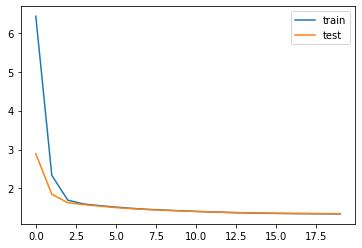

In [8]:
plt.plot(range(n_epochs), train_losses)
plt.plot(range(n_epochs), test_losses)
plt.legend(['train', 'test'])

In [0]:
def show_density(model):
    xs = np.linspace(-4, 4, 100)
    pdfs = []
    for x in xs[::-1]:
        sample = torch.tensor(np.vstack([xs, [x] * 100]).transpose(), dtype=torch.float32)
        #print(sample)
        pdf, _ = model(sample)
        pdfs.append(pdf.detach().numpy())

    plt.imshow(pdfs)
    plt.show()

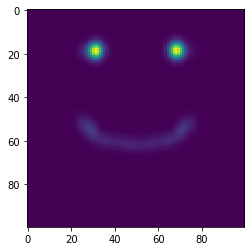

In [10]:
show_density(model)

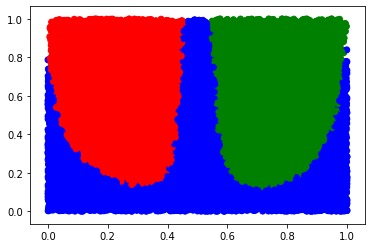

In [11]:
pdf, cdf = model(X_test)
display(cdf.detach().numpy(), y_test)

#1.2

In [0]:
class MLP(nn.Module):
    def __init__(self, n_hidden=3, nin=1, nout=1):
        super(MLP, self).__init__()
        self.layers = []
        self.layers.extend([
            nn.Linear(nin, 40),
            nn.Sigmoid(),
            nn.Dropout(0.5)
        ])
        for i in range(1, n_hidden - 1):
            self.layers.extend([
                nn.Linear(40, 40),
                nn.Sigmoid(),
                nn.Dropout(0.5)
            ])
        self.layers.extend([
            nn.Linear(40, nout),
            nn.Sigmoid()
        ])
        torch.nn.init.normal_(self.layers[0].weight)
        self.model = nn.Sequential(*self.layers)
    
    def forward(self, x):
        return self.model(x)

class Coupling(nn.Module):
    def __init__(self):
        super(Coupling, self).__init__()
        self.s = MLP()
        self.t = MLP()

    def forward(self, x):
        x1 = x[:,0:1]
        x2 = x[:,1:2]
        y2 = x1
        s = self.s(x1)
        t = self.t(x1)
        y1 = x2 * s + t
        cdf = torch.cat((y1.reshape(-1), y2.reshape(-1))).reshape(2, -1).transpose(0, 1)
        log_pdf = torch.log(s + 1e-9).reshape(-1, 1);
        return log_pdf, cdf

class ActivNorm(nn.Module):
    def __init__(self):
        super(ActivNorm, self).__init__()
        self.w = nn.Parameter(torch.ones(2))
        self.b = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        cdf = self.w * x + self.b
        log_pdf = torch.log(self.w.abs() + 1e-9).sum(axis=-1).reshape(-1, 1)
        return log_pdf, cdf

class RealNVP(nn.Module):
    EPS = 1e-9
    def __init__(self, k):
        super(RealNVP, self).__init__()
        self.seq = nn.ModuleList()
        for i in range(k):
            self.seq.append(Coupling())
            self.seq.append(ActivNorm())
        
    def forward(self, x):
        log_pdf = torch.ones((x.shape[0], 1), dtype=torch.float32)
        cdf = x
        for layer in self.seq:
            log_pdf_1, cdf = layer(cdf)
            #print(pdf_1.shape, pdf.shape)
            log_pdf += log_pdf_1
        
        cdf = torch.sigmoid(cdf)
        log_pdf += torch.log(cdf * (1 - cdf) + 1e-9).sum(axis=-1).reshape(-1, 1)
        return torch.exp(log_pdf.reshape(-1)), cdf


In [26]:
model = RealNVP(10)
adam = optim.Adam(model.parameters())
n_epochs = 20

train_losses = []
test_losses = []
for i in tqdm(range(n_epochs)):
    losses_epoch = []
    for batch in dataset:
        adam.zero_grad()
        pdf, _ = model(batch)
        #print(pdf)
        #print(pdf)
        loss = J(pdf)
        #print(loss)
        losses_epoch.append(float(loss.float()))
        loss.backward()
        adam.step()
        #print(np.max([par.max() for par in model.parameters()]))
    train_losses.append(np.mean(losses_epoch))
    pdf, cdf = model(X_test)
    test_losses.append(float(J(pdf)))

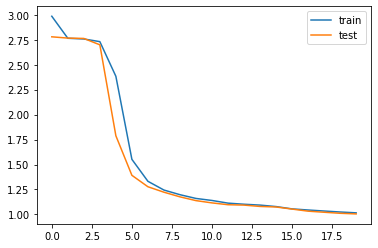

In [27]:
plt.plot(range(n_epochs), train_losses)
plt.plot(range(n_epochs), test_losses)
plt.legend(['train', 'test'])

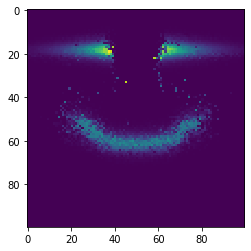

In [28]:
show_density(model)

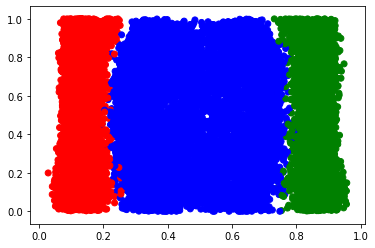

In [29]:
pdf, cdf = model(X_test)
display(cdf.detach().numpy(), y_test)